# WTB

Automatic classification of birds for this project : http://www.cabane-oiseaux.org/

## Data cooking
First, prepare the data : we need a train dataset and a validation dataset.
We use the Keras ImageDataGenerator that can build a training set from directories containing images.
Each sub directory must contains a category of bird : Keras will associate each one to a category in the model.

In [1]:
IMG_ROWS = 224
IMG_COLS = 224
EPOCHS = 10
BATCH_SIZE = 32
DIR_TRAIN = '/home/kvjw3322/Documents/CodingDojoML/WTB/photos/photos_train'
DIR_VALID = '/home/kvjw3322/Documents/CodingDojoML/WTB/photos/photos_valid'
DIR_TEST = '/home/kvjw3322/Documents/CodingDojoML/WTB/photos/photos_test'

In [2]:
import PIL
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras import applications
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import json

# Generator for train
train_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
train_iterator = train_image_generator.flow_from_directory(
    DIR_TRAIN, # Root directory
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical') # Each subdir is a category

# Generator for validation
valid_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
valid_iterator = valid_image_generator.flow_from_directory(
    DIR_VALID,
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical')

# Generator for test
test_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
test_iterator = test_image_generator.flow_from_directory(
    DIR_TEST,
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical',
    shuffle=False)

# Number of classes
NUM_OF_CLASSES = len(train_iterator.class_indices)

Using TensorFlow backend.


Found 7526 images belonging to 7 classes.
Found 2164 images belonging to 7 classes.
Found 1084 images belonging to 7 classes.


In [3]:
NUM_OF_TRAIN_SAMPLES = train_iterator.samples
NUM_OF_VALID_SAMPLES = valid_iterator.samples
NUM_OF_TEST_SAMPLES = test_iterator.samples

In [4]:
# This Keras Callbak saves the best model according to the accuracy metric
filepath="../models/bestmodel-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [5]:
test_iterator.reset()
mapper = { v:k for k,v in test_iterator.class_indices.items()}


with open('../mapper.json', 'w') as fp:
    json.dump(mapper, fp)

# Fine Tuning

> Note : network that relies on a pre-trained model, VGG16.


In [6]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_ROWS, IMG_COLS, 3))

In [102]:
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD

model_ft_top = Sequential()
model_ft_top.add(Flatten())
model_ft_top.add(Dense(1024, activation="relu"))
model_ft_top.add(Dropout(0.5))
model_ft_top.add(Dense(NUM_OF_CLASSES, activation="softmax"))

# The model must have weight initialized (compile ? load weight ?)
# model_ft.load_weights()

model_ft = Model(input=base_model.input, output=model_ft_top(base_model.output))

# Freeze the 16th first layers
for layer in model_ft.layers[:15]:
    layer.trainable = False

model_ft.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/home/kvjw3322/.virtualenvs/p3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [16]:
model_ft.fit_generator(generator=train_iterator, 
                    steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_iterator,
                    validation_steps=NUM_OF_VALID_SAMPLES // BATCH_SIZE,
                    callbacks=[checkpoint])
                    

Epoch 1/10
235/235 [==============================] - 2201s 9s/step - loss: 1.2472 - acc: 0.8182 - val_loss: 0.2680 - val_acc: 0.9230

Epoch 00001: val_acc improved from -inf to 0.92304, saving model to ../models/bestmodel-01-0.92.hdf5
Epoch 2/10
235/235 [==============================] - 2176s 9s/step - loss: 0.1390 - acc: 0.9557 - val_loss: 0.2341 - val_acc: 0.9451

Epoch 00002: val_acc improved from 0.92304 to 0.94512, saving model to ../models/bestmodel-02-0.95.hdf5
Epoch 3/10
235/235 [==============================] - 2178s 9s/step - loss: 0.0579 - acc: 0.9824 - val_loss: 0.1913 - val_acc: 0.9536

Epoch 00003: val_acc improved from 0.94512 to 0.95356, saving model to ../models/bestmodel-03-0.95.hdf5
Epoch 4/10
235/235 [==============================] - 2179s 9s/step - loss: 0.0331 - acc: 0.9888 - val_loss: 0.2510 - val_acc: 0.9522

Epoch 00004: val_acc did not improve from 0.95356
Epoch 5/10
235/235 [==============================] - 2176s 9s/step - loss: 0.0198 - acc: 0.9943 - va

In [5]:
model_ft = keras.models.load_model("/home/kvjw3322/Developement/WTB/models/bestmodel-09-0.97.hdf5")

## Confusion Matrix
Let's valid our model and search for weakness ! The confusion matrix displays in a table the result of all the predictions : each column represents a given category for prediction, each row represents a given category for expected result. The data shown in the matrix diagonal are the correct predictions. Any other cell is a confusion between two classes.

In [6]:
# Source : https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
# Function to plot a pretty confusion matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [7]:
test_iterator.reset()
# Compute prediction for all test samples
Y_pred = model_ft.predict_generator(test_iterator, NUM_OF_TEST_SAMPLES // BATCH_SIZE+1)

# For each prediction, get the "best" class
y_pred = np.argmax(Y_pred, axis=1)

In [8]:
classes = test_iterator.classes[test_iterator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/NUM_OF_TEST_SAMPLES

0.940959409594096

In [9]:
from sklearn.metrics import confusion_matrix 

plot_confusion_matrix(confusion_matrix(test_iterator.classes[test_iterator.index_array], y_pred),
                          list(test_iterator.class_indices.keys()), normalize=False)

<Figure size 800x600 with 2 Axes>

## Classification report

In [10]:
from sklearn.metrics import classification_report

print(classification_report(test_iterator.classes, y_pred, target_names=list(test_iterator.class_indices.keys())))

                      precision    recall  f1-score   support

   accenteur mouchet       0.96      0.97      0.97       160
        mesange bleu       0.93      0.93      0.93       154
mesange charbonniere       0.96      0.90      0.93       154
              pinson       0.96      0.80      0.87       155
         rouge gorge       0.99      0.99      0.99       153
             verdier       0.82      1.00      0.90       155
                vide       0.99      1.00      1.00       153

           micro avg       0.94      0.94      0.94      1084
           macro avg       0.95      0.94      0.94      1084
        weighted avg       0.95      0.94      0.94      1084



## Manual validation

In [13]:
from random import randint
from keras.preprocessing.image import DirectoryIterator
def get_random_image(image_iterator: DirectoryIterator) -> (str, str, int, dict):
    picture_path = image_iterator.filenames[randint(0, len(image_iterator.filenames)-1)]
    category = os.path.dirname(picture_path)
    mapper = { v:k for k,v in image_iterator.class_indices.items()}

    return os.path.join(image_iterator.directory, picture_path), category,  mapper

In [14]:
def predict(picture_path:str, mapper:dict):
    picture = PIL.Image.open(picture_path)
    picture = picture.resize(size=(224,224))
    picture_array = img_to_array(img=picture)
    picture_array = np.expand_dims(picture_array, axis=0)
    prediction = model_ft.predict(keras.applications.vgg16.preprocess_input(picture_array))
    return mapper.get(np.argmax(prediction, axis=1)[0]), prediction

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 rouge gorge ? That was a rouge gorge Proba :[[6.97693113e-20 9.37340890e-15 2.42953190e-16 1.71233650e-19
  1.00000000e+00 1.43322567e-16 1.32519785e-17]] 


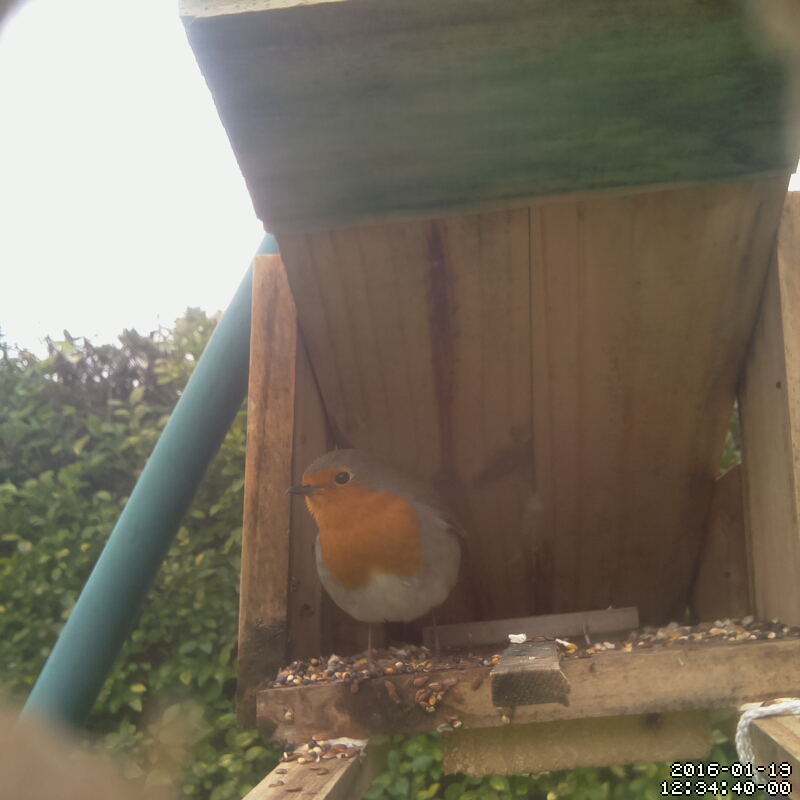

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 accenteur mouchet ? That was a accenteur mouchet Proba :[[1.0000000e+00 6.2083519e-11 1.6074402e-09 1.4770964e-10 9.5808494e-10
  1.6337380e-09 4.0582475e-11]] 


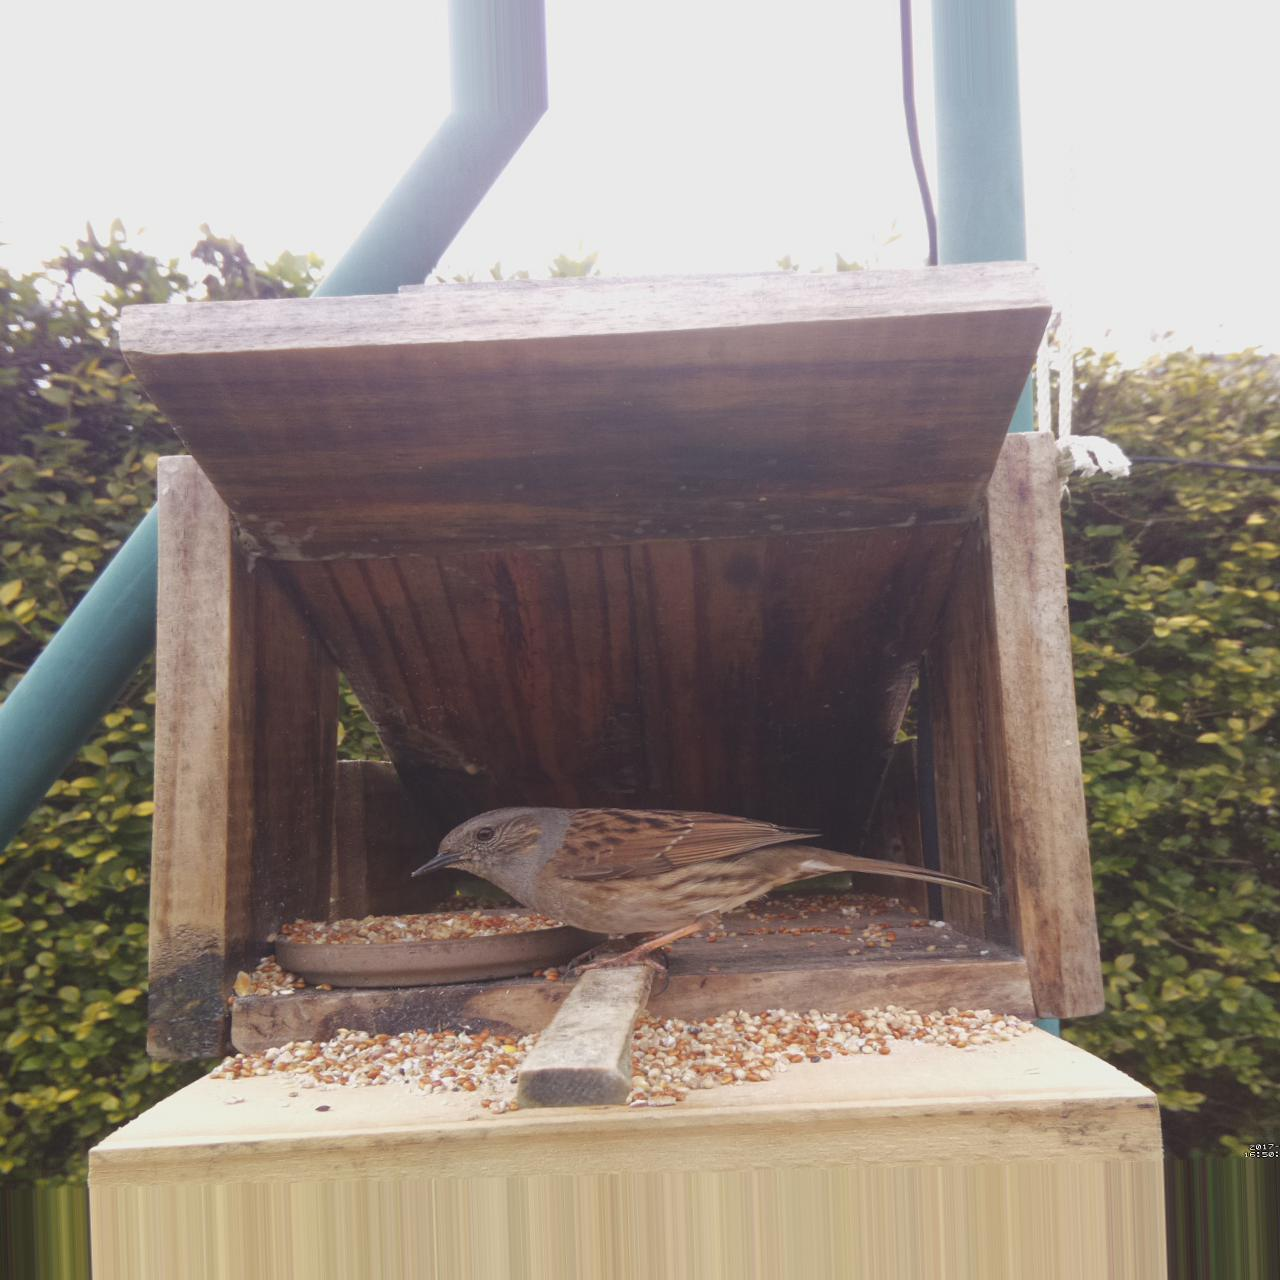

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 mesange bleu ? That was a mesange bleu Proba :[[6.9915787e-14 9.9999225e-01 7.2466482e-06 8.9771757e-14 5.0732643e-07
  3.3805375e-11 2.0177211e-12]] 


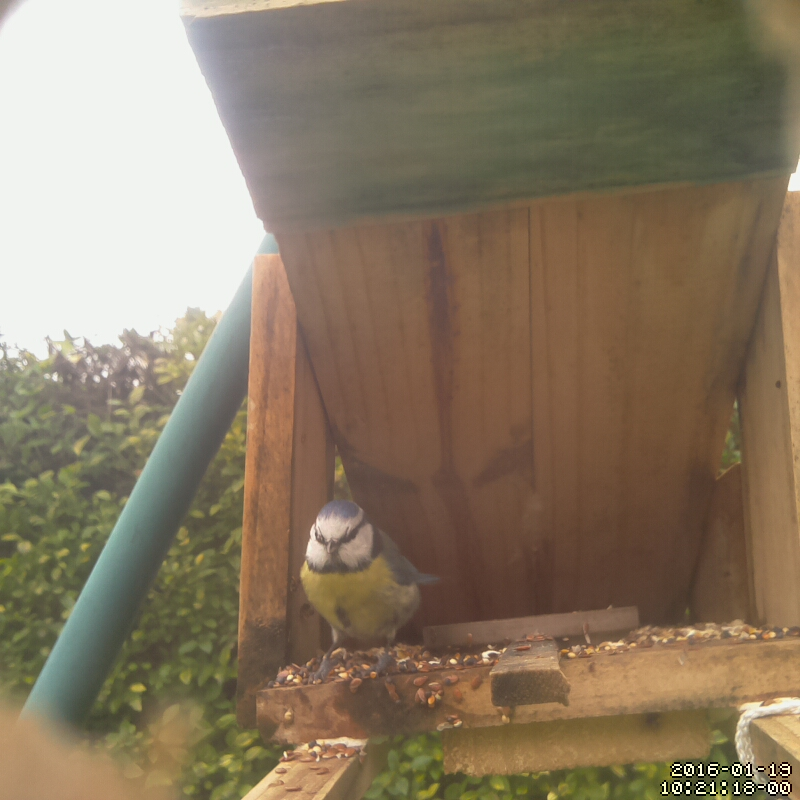

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 mesange bleu ? That was a mesange bleu Proba :[[2.1565378e-16 9.9999952e-01 4.8430422e-07 7.3707219e-16 6.4894151e-18
  2.3153219e-13 1.6012820e-17]] 


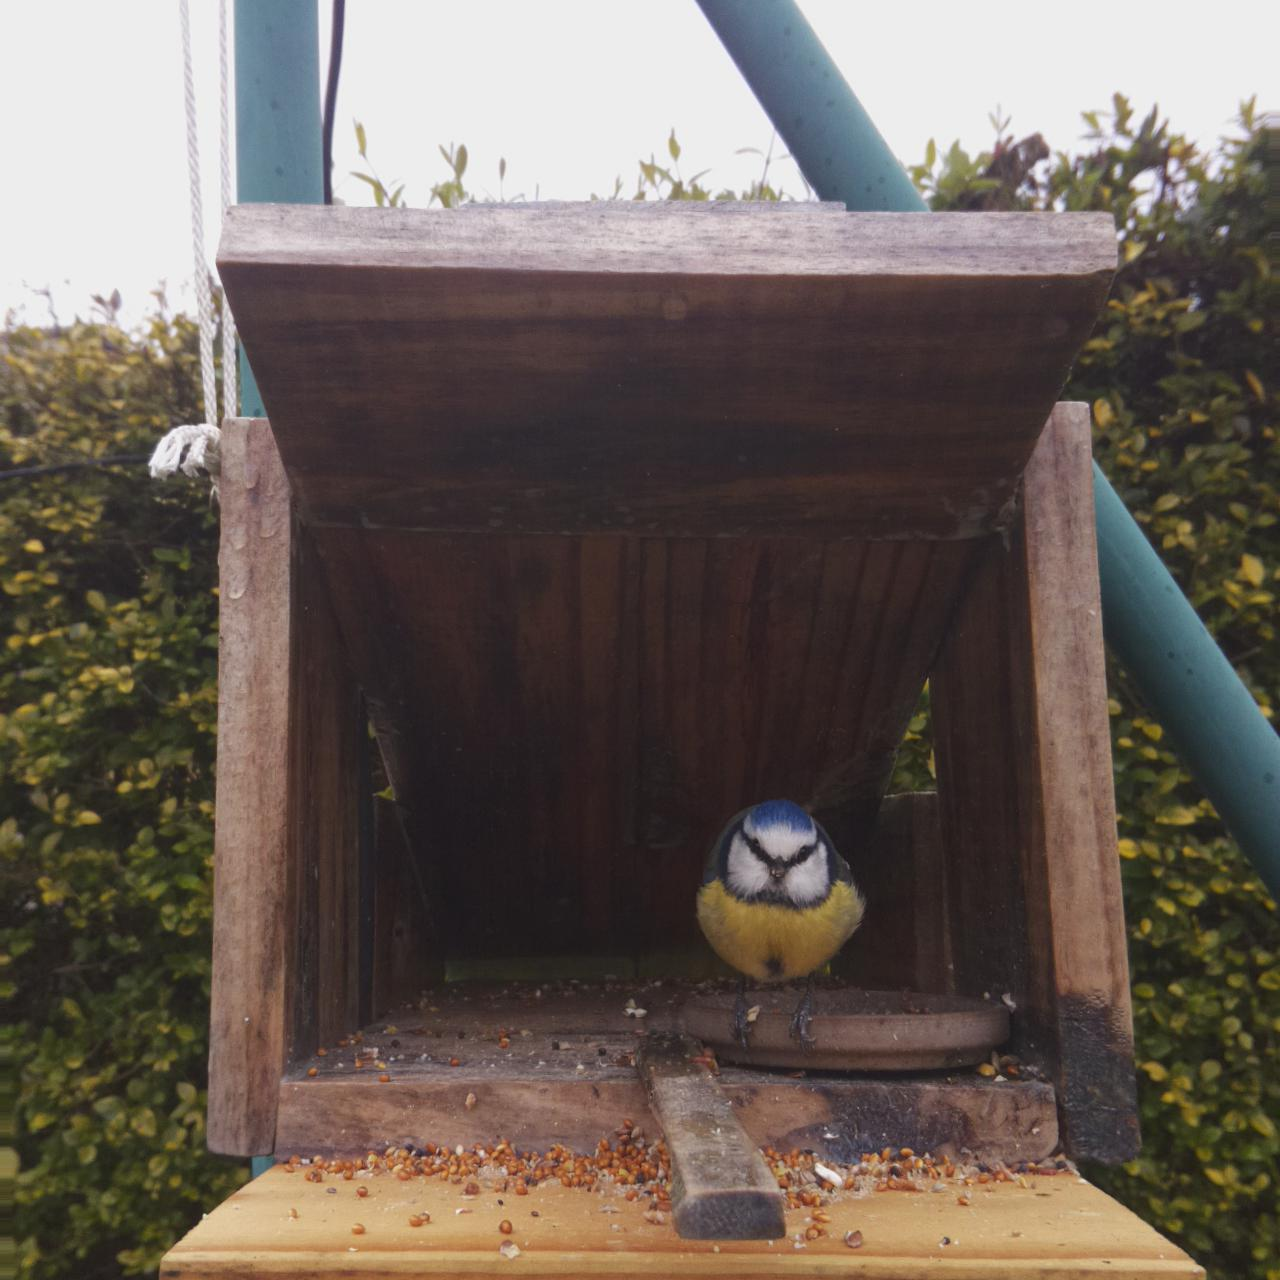

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 accenteur mouchet ? That was a accenteur mouchet Proba :[[9.9999976e-01 3.2141945e-09 2.1828159e-09 2.0344104e-09 2.1836030e-07
  3.6161947e-09 1.5856247e-09]] 


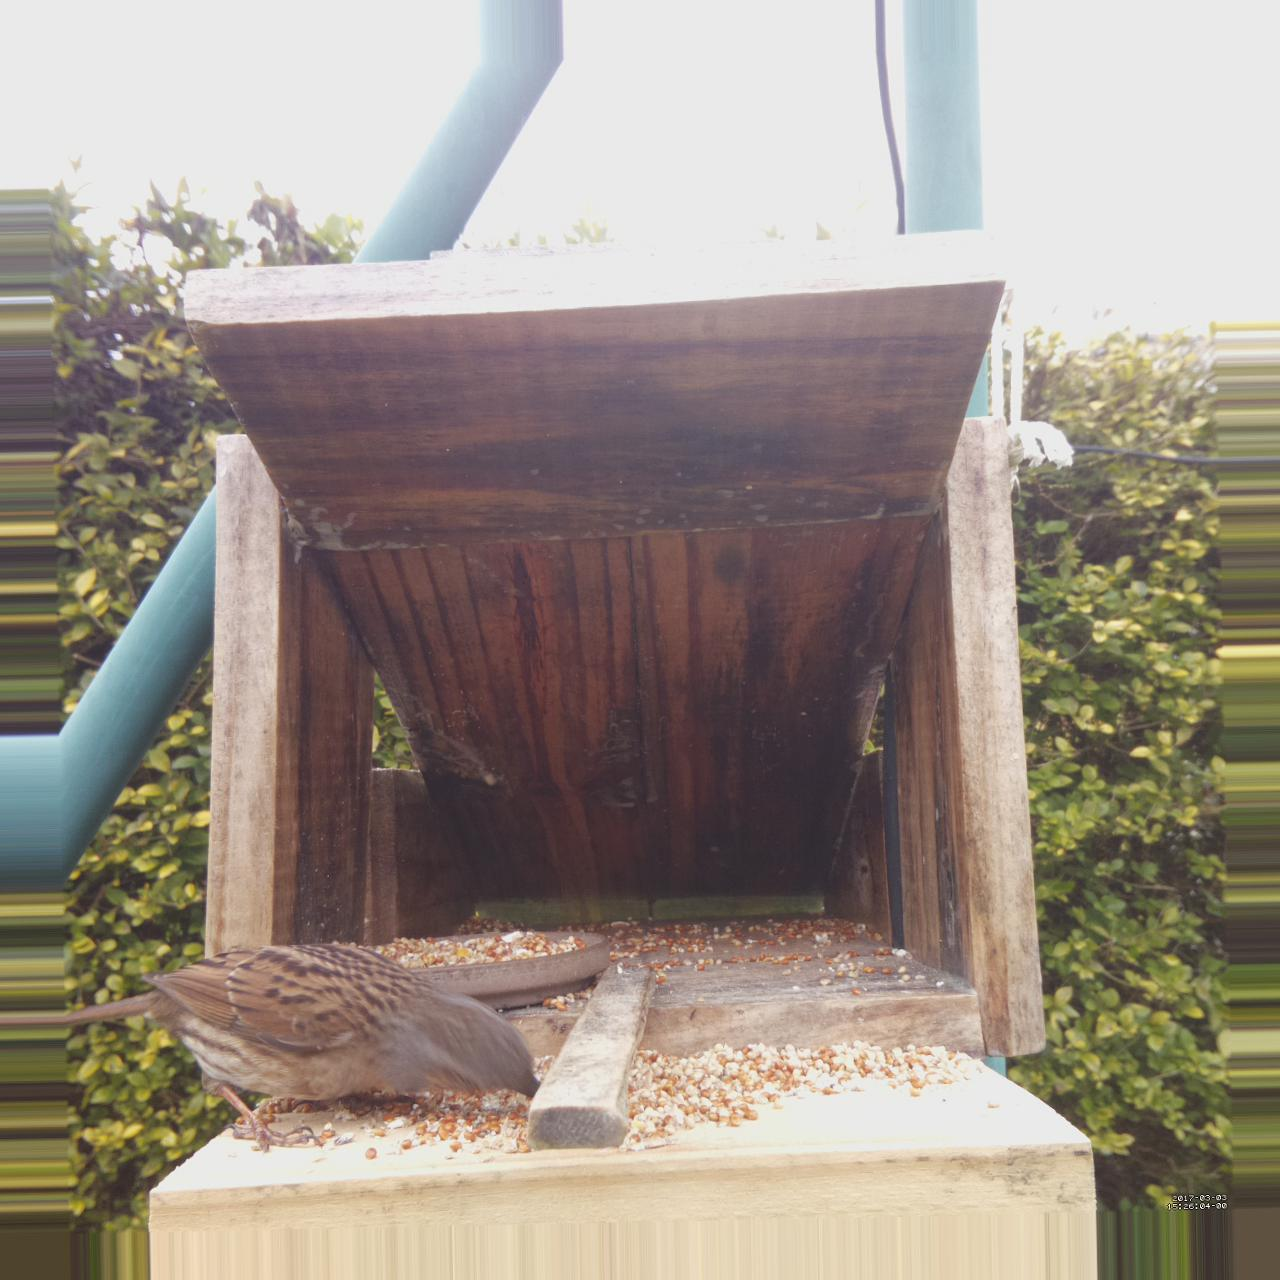

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 mesange bleu ? That was a mesange bleu Proba :[[1.0528150e-21 9.9999893e-01 1.0779278e-06 3.7531422e-21 5.9409869e-21
  2.1505593e-13 2.4276413e-22]] 


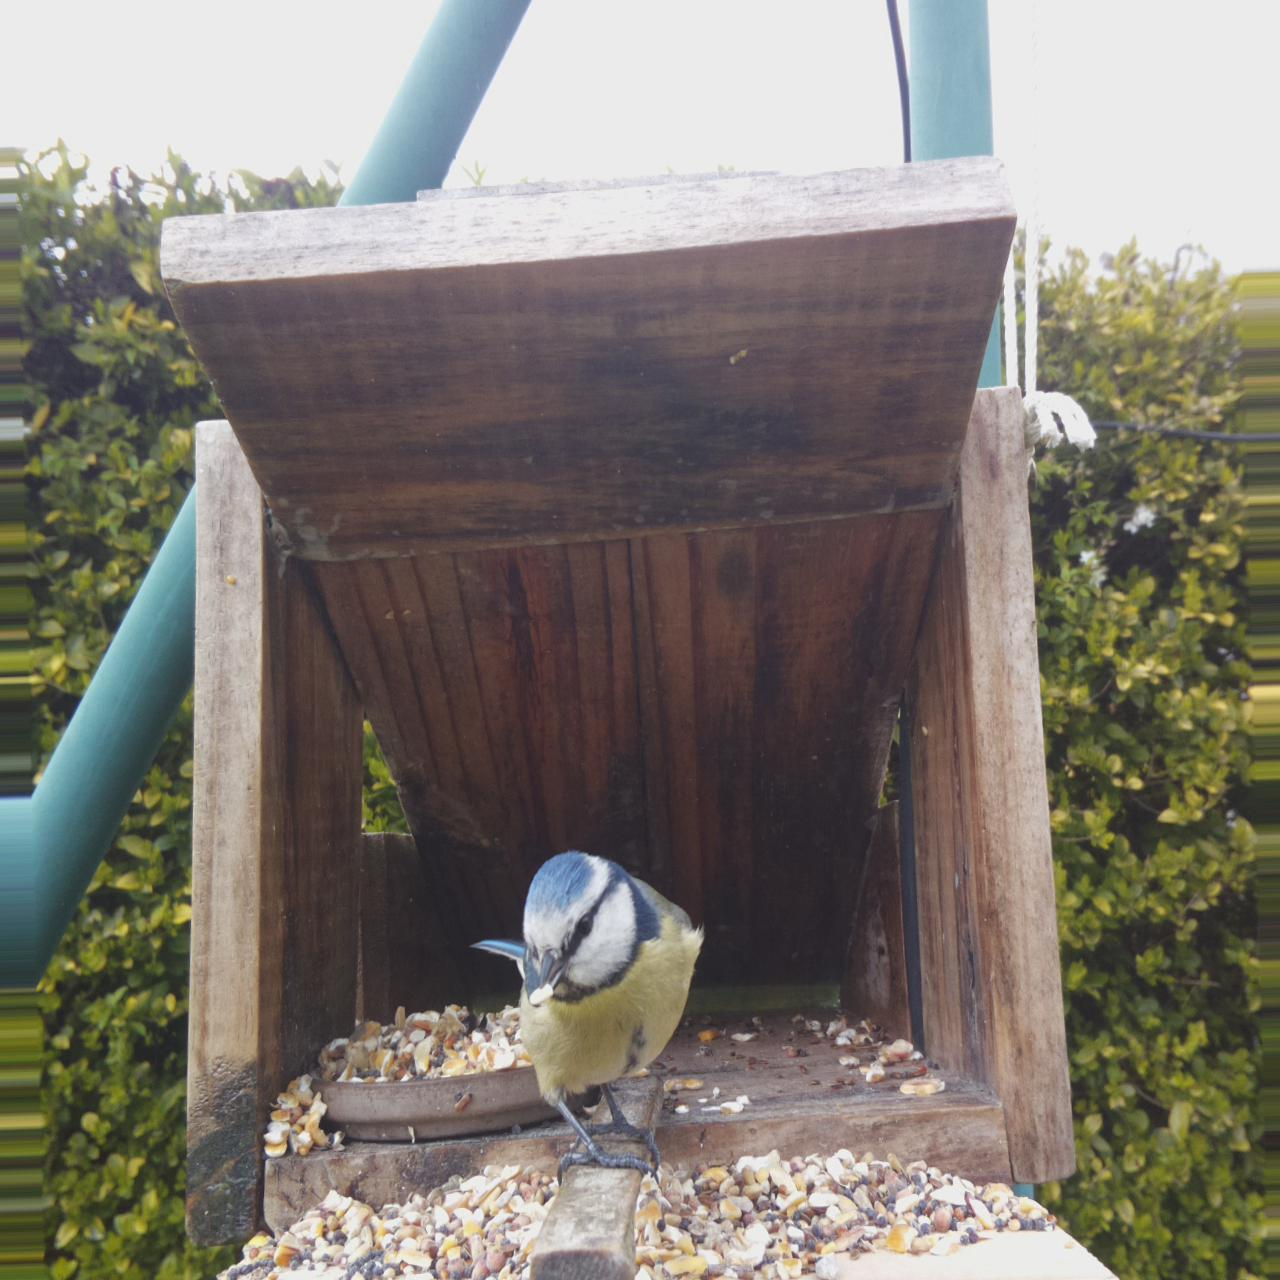

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 mesange charbonniere ? That was a mesange charbonniere Proba :[[4.8656771e-13 2.6426607e-08 1.0000000e+00 4.0017039e-12 1.9080069e-11
  6.0212872e-12 6.4306243e-13]] 


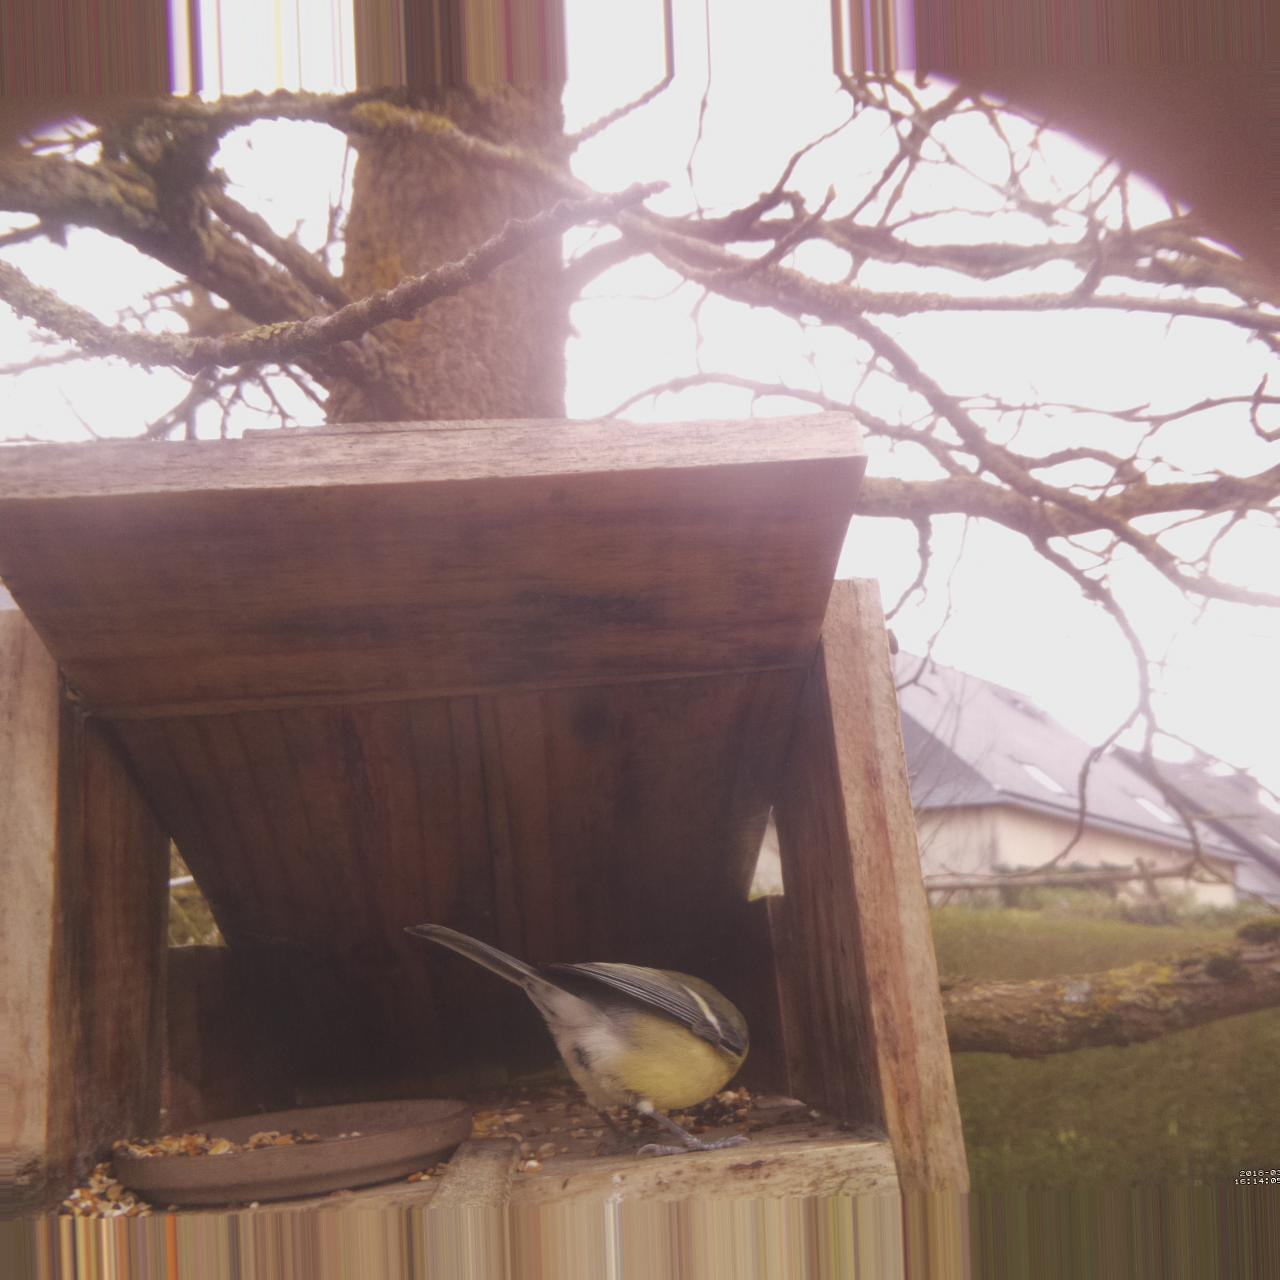

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 accenteur mouchet ? That was a accenteur mouchet Proba :[[9.99990106e-01 1.95291712e-08 3.20516421e-07 2.66555020e-07
  1.05393035e-07 9.21576157e-06 4.68264290e-08]] 


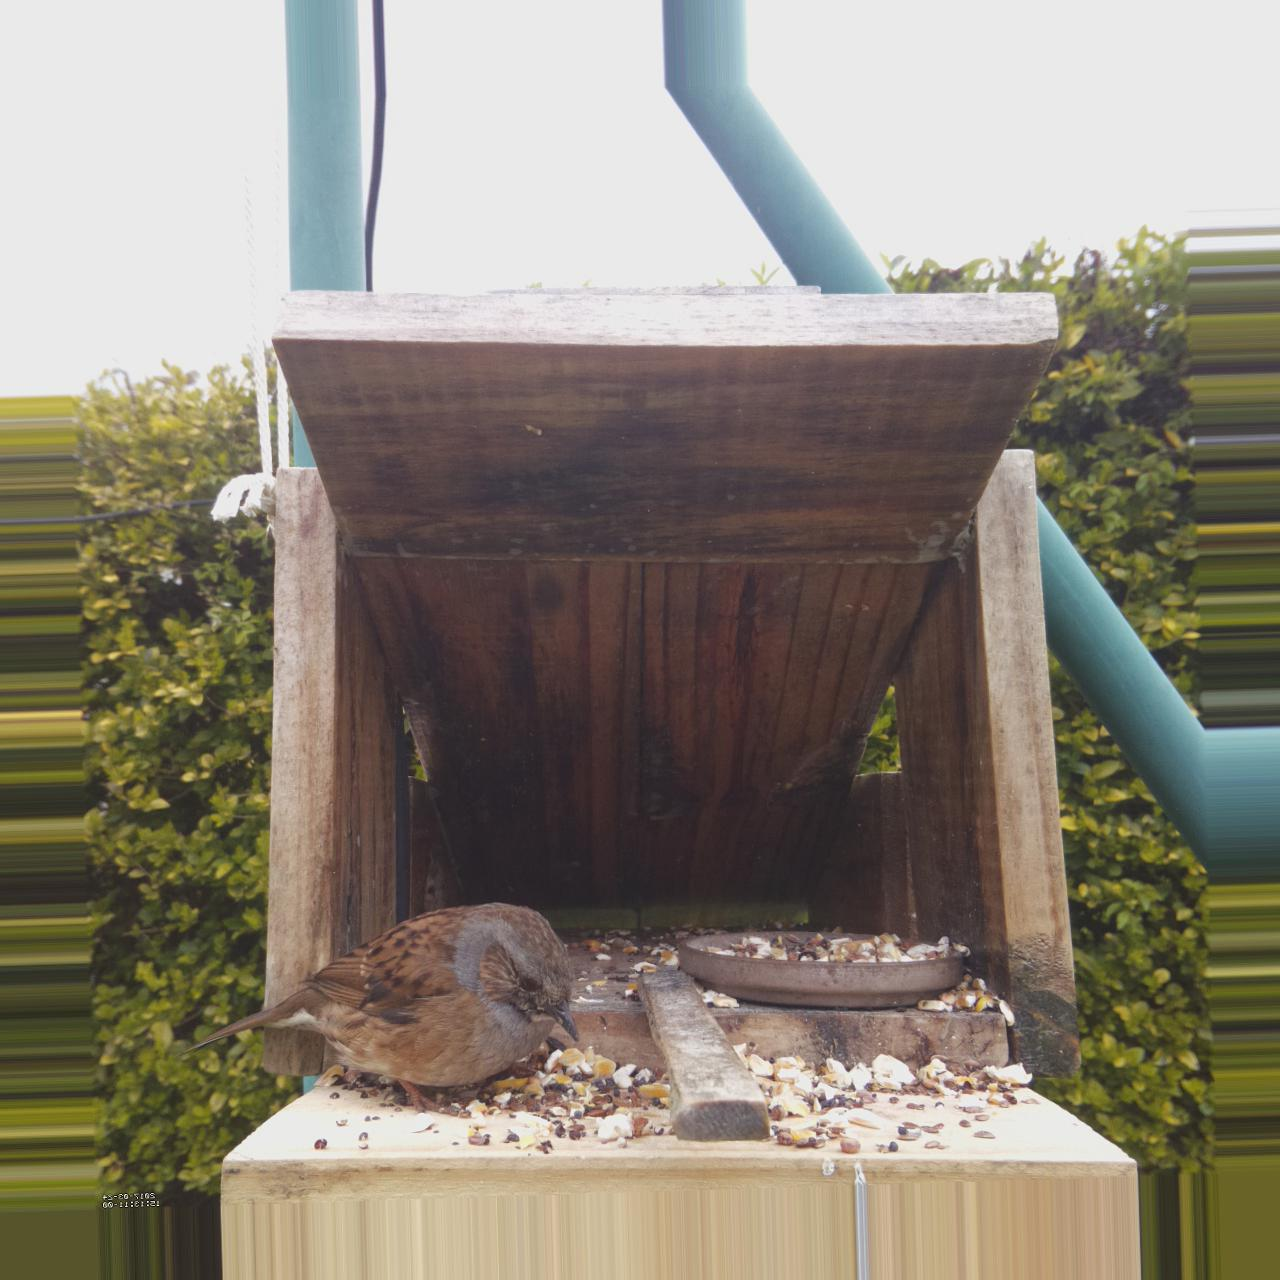

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 vide ? That was a vide Proba :[[4.0832075e-09 1.2800289e-06 2.4266191e-09 6.8231387e-10 2.8161145e-07
  1.3083540e-09 9.9999845e-01]] 


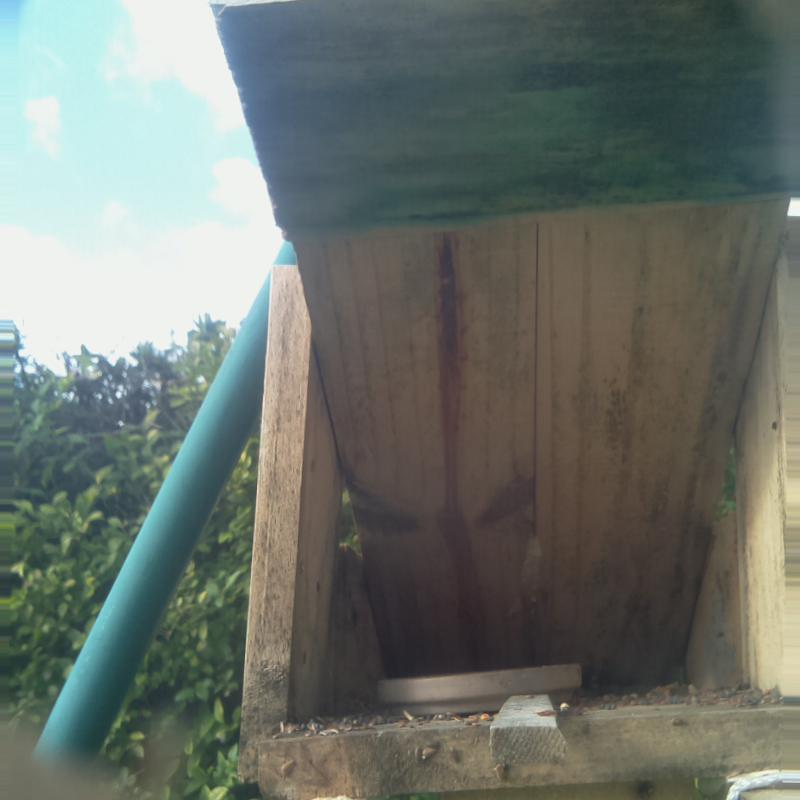

{0: 'accenteur mouchet', 1: 'mesange bleu', 2: 'mesange charbonniere', 3: 'pinson', 4: 'rouge gorge', 5: 'verdier', 6: 'vide'}
 verdier ? That was a verdier Proba :[[1.3565653e-09 2.6544359e-07 5.0621388e-06 6.5089434e-11 9.8720419e-09
  9.9999464e-01 5.1123494e-11]] 


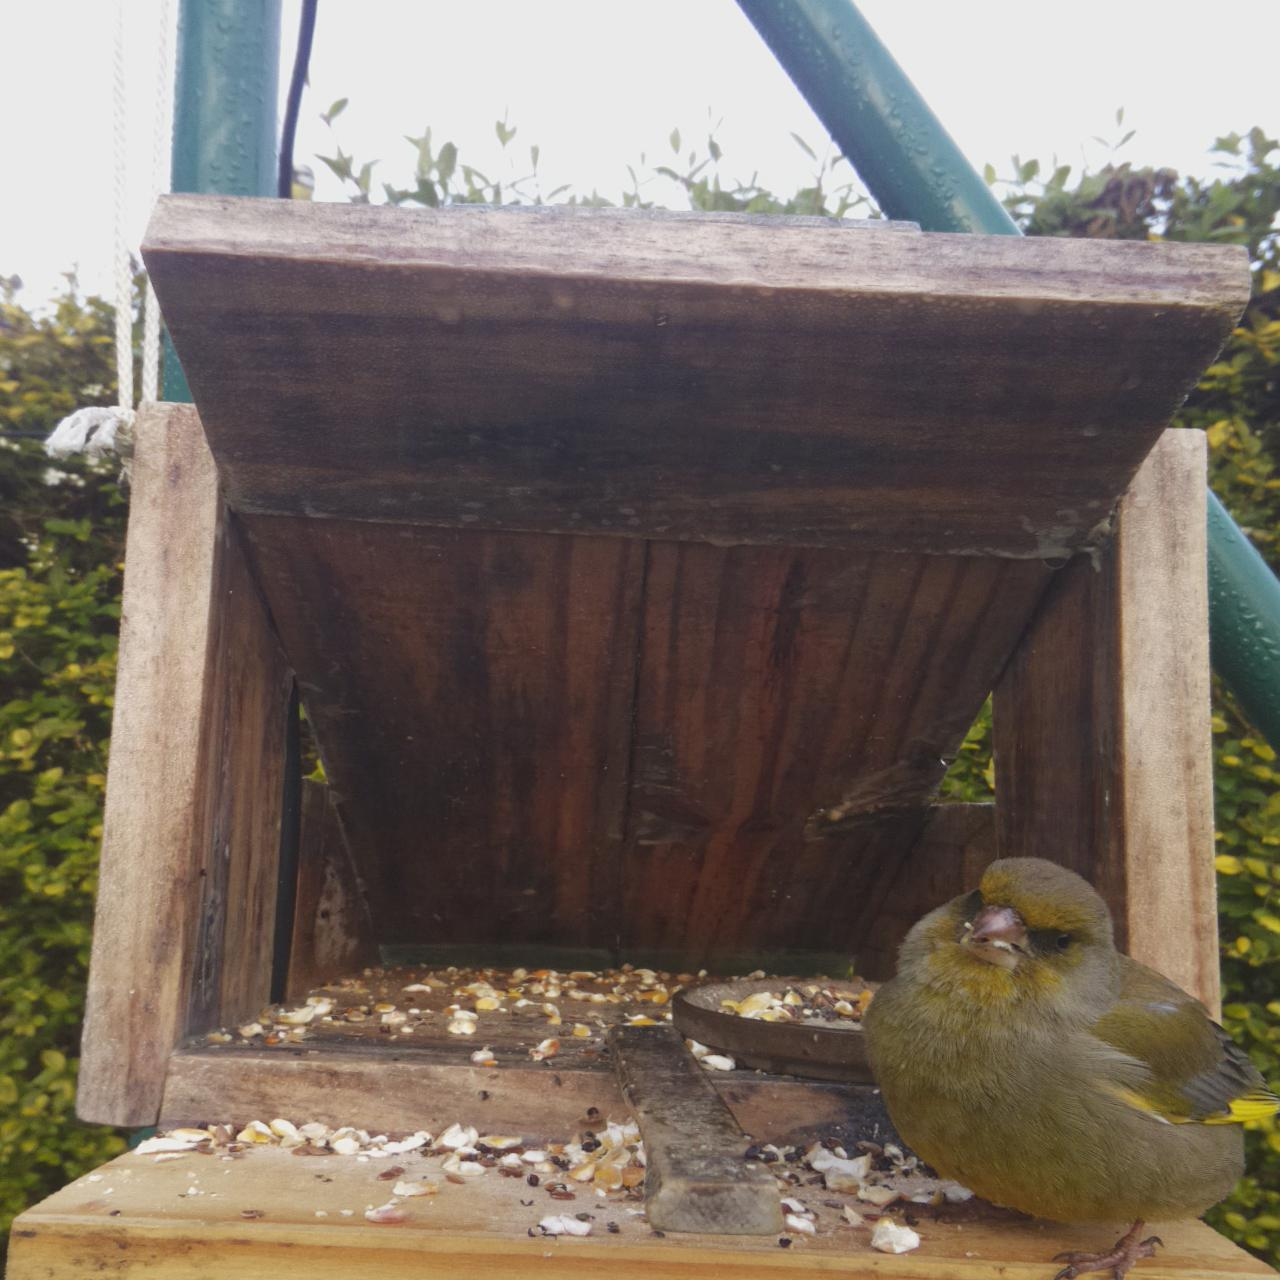


Ok : 10 / Ko : 0


In [15]:
import IPython.display
TESTS = 10

ok = 0
ko = 0
test_iterator.reset()
for _ in range(TESTS):
    picture_path, category, mapper = get_random_image(test_iterator)
    print(mapper)
    label, prediction = predict(picture_path, mapper)
    bg_color = "102"
    if label != category:
        bg_color = "101"
        ko += 1
    else:
        ok += 1
    print(f"\x1b[{bg_color};37m {label} ? That was a {category} Proba :{prediction} \x1b[0m")
    IPython.display.display(IPython.display.Image(picture_path, width=200))

print(f"\nOk : {ok} / Ko : {ko}")


In [37]:
mapper = { v:k for k,v in test_iterator.class_indices.items()}
os.listdir("/home/kvjw3322/Developement/WTB/photos/")

['photos_train',
 'photos_origin',
 'photos_valid',
 'rougegorge.familier.seva.1g.jpg',
 '89063658_o.jpg',
 'photos.zip',
 'rougegorge.familier.alch.6p.jpg',
 'photos_test']

In [16]:
predict("/home/kvjw3322/Developement/WTB/photos/rougegorge.familier.alch.6p.jpg", mapper)

('mesange charbonniere',
 array([[6.8180100e-10, 8.4723837e-08, 9.9999988e-01, 1.0440124e-08,
         5.7371423e-08, 9.5321711e-12, 3.0721480e-08]], dtype=float32))

In [17]:
imagenet_model = applications.VGG16(weights='imagenet', include_top=True, input_shape=(IMG_ROWS, IMG_COLS, 3))

In [18]:
test_iterator.reset()
# Compute prediction for all test samples
Y_pred = imagenet_model.predict_generator(test_iterator, NUM_OF_TEST_SAMPLES // BATCH_SIZE+1)

# For each prediction, get the "best" class
y_pred = np.argmax(Y_pred, axis=1)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(test_iterator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.00      0.00      0.00       154
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00       153
           5       0.00      0.00      0.00       155
           6       0.00      0.00      0.00       153
           8       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          85       0.00      0.00      0.00         0
          86       0.00      0.00      0.00         0
          89       0.00    

/home/kvjw3322/.virtualenvs/p3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kvjw3322/.virtualenvs/p3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
def predict_imagenet(picture_path:str):
    picture = PIL.Image.open(picture_path)
    picture = picture.resize(size=(224,224))
    picture_array = img_to_array(img=picture)
    picture_array = np.expand_dims(picture_array, axis=0)
    prediction = imagenet_model.predict(keras.applications.vgg16.preprocess_input(picture_array))
    return np.argmax(prediction, axis=1)[0], prediction

In [33]:
from keras.applications.imagenet_utils import decode_predictions

for _ in range(TESTS):
    picture_path, category, mapper = get_random_image(test_iterator)
    label, prediction = predict_imagenet(picture_path)
    print(picture_path, decode_predictions(prediction))

/home/kvjw3322/Developement/WTB/photos/photos_test/mesange bleu/01-20170311_085626-00.jpg [[('n03467068', 'guillotine', 0.33323365), ('n03903868', 'pedestal', 0.14498614), ('n02727426', 'apiary', 0.0909236), ('n04355338', 'sundial', 0.056323722), ('n03530642', 'honeycomb', 0.027655274)]]
/home/kvjw3322/Developement/WTB/photos/photos_test/mesange charbonniere/generated_00_02-20180319_115712-00.jpg [[('n03467068', 'guillotine', 0.14347579), ('n03764736', 'milk_can', 0.0823113), ('n02939185', 'caldron', 0.060646288), ('n02797295', 'barrow', 0.0543057), ('n02843684', 'birdhouse', 0.046275854)]]
/home/kvjw3322/Developement/WTB/photos/photos_test/vide/generated_03_04-20160331_142929-00.jpg [[('n02843684', 'birdhouse', 0.15849094), ('n04049303', 'rain_barrel', 0.15629007), ('n02788148', 'bannister', 0.099196516), ('n03388043', 'fountain', 0.08097724), ('n03930313', 'picket_fence', 0.029553723)]]
/home/kvjw3322/Developement/WTB/photos/photos_test/mesange charbonniere/generated_00_01-20180320_0

## RNN : layer by layer

> note : network built from scratch, without any pre-trained layer

We build the RNN, adding layers one by one

- Conv2D : The input_shape is 150,150 to match the images size. The last dimension is '3' because each pixel is represented by 3 values (RGB). For grayscale images, this parameter would have been '1' (one value to store the grey level). We choose to use 32 filters (or feature maps) : all the filters are appyed to the source image at the same time. The convolution layer "learn" the values of each filter (as synaptic coefficients are in a Dense hidden layer). The kernel_size is the matrix size of the filter
- MaxPooling2D : The subsampling layer get the best value (max with maxpooling) of a set of x pixels. This set comes from a sub matrix of "pool_size"

In [13]:
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model, Sequential

model = Sequential() 
model.add(Conv2D(filters=32, input_shape=(IMG_ROWS, IMG_COLS, 3), kernel_size=(5,5)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

# Transform the output matrix into a vector for the Dense layer
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(NUM_OF_CLASSES, activation="softmax"))

## Let's learn !
It's time to make our network learn : we compile it (as Keras ask us to), and run the learning from our data.

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(generator=train_iterator, 
                    steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_iterator,
                    validation_steps=NUM_OF_TEST_SAMPLES // BATCH_SIZE,
                    callbacks=[checkpoint])